## Libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)

from xgboost import XGBRegressor

## Data Preparation

In [2]:
# Load dataset
df = pd.read_csv("sales.csv", sep=";")

# Rename columns
df = (
    df.rename(columns={"Posting Date": "date"})
      .rename(columns=str.lower)
)

# Convert data types
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
df['material'] = df['material'].astype(str)
df['quantity'] = (
    df['quantity']
    .astype(str)
    .str.replace('.', '', regex=False)
    .str.replace(',', '.', regex=False)
)
df['quantity'] = pd.to_numeric(df['quantity'])

# Remove negative and zero quantities (business rule)
df = df[df['quantity'] > 0]

# Aggregate by date, plant, and material
df = df.groupby(['date', 'plant', 'material'], as_index=False)['quantity'].sum()
df.set_index('date', inplace=True)

# Filter only plant 'loc30' and drop unused columns
df = df[df['plant'] == 'loc30']
df.drop(columns=['plant', 'material'], inplace=True)

# Resample to daily frequency and fill missing dates with 0 sales
df = df.asfreq('D')
df.fillna(0, inplace=True)

## Exploratory Visualization

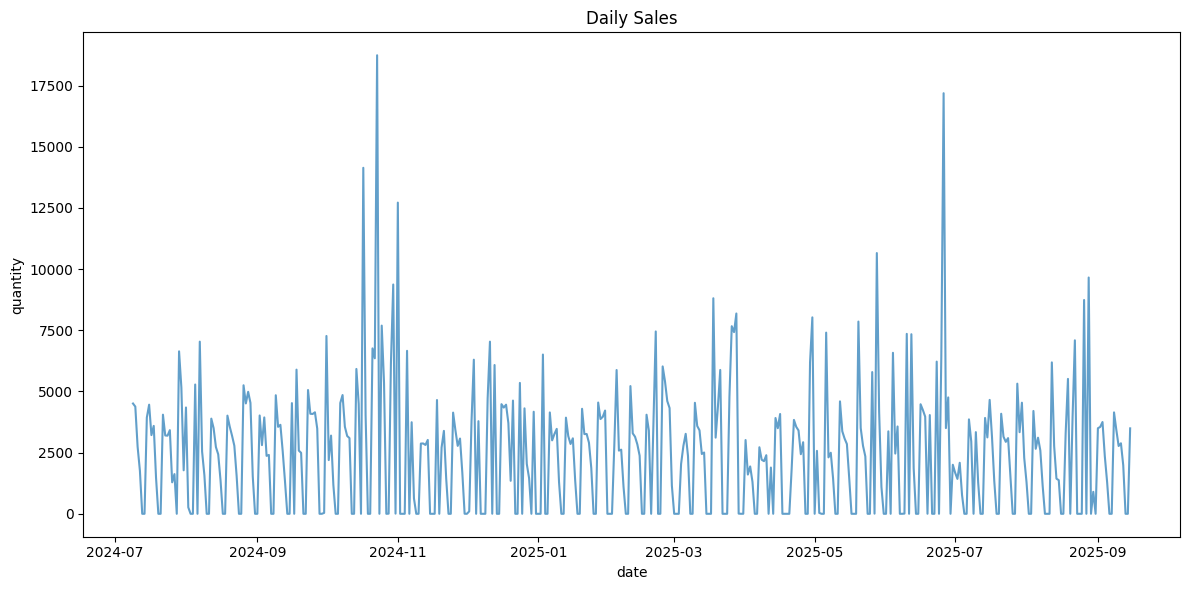

In [3]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x=df.index, y='quantity', alpha=0.7)
plt.title("Daily Sales")
plt.tight_layout()
plt.show()

## Functions

In [4]:
def create_dashboard(df, model_name: str):
    """
    Plot actual vs forecast sales for a given model.
    """
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x=df.index, y='quantity', label='Actual', alpha=0.7)
    sns.lineplot(
        data=df,
        x=df.index,
        y=f'{model_name} quantity',
        label='Forecast',
        alpha=0.7
    )
    plt.title(f"{model_name} - Forecast vs Actual")
    plt.legend()
    plt.xlim(left=df.index[0])
    plt.tight_layout()
    plt.show()

In [5]:
def print_metrics(y_true, y_pred, model_name: str = ""):
    """
    Print common regression metrics for a given model.
    """
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{model_name}:")
    print(f"  MSE = {mse:.4f}")
    print(f"  MAE = {mae:.4f}")
    print(f"  R²  = {r2:.4f}")
    print("-" * 30)

## Feature Engineering

In [6]:
df['day'] = df.index.day
df['month'] = df.index.month
df['year'] = df.index.year
df['day_of_week'] = df.index.dayofweek
df['day_of_month'] = df.index.day
df['day_of_year'] = df.index.dayofyear
df['week_of_year'] = df.index.isocalendar().week
df['is_weekend'] = np.where(df['day_of_week'].isin([5, 6]), 1, 0)

df.head()

,quantity,day,month,year,day_of_week,day_of_month,day_of_year,week_of_year,is_weekend
date,,,,,,,,,
2024-07-09,4506.0,9,7,2024,1,9,191,28,0
2024-07-10,4379.7,10,7,2024,2,10,192,28,0
2024-07-11,2737.7,11,7,2024,3,11,193,28,0
2024-07-12,1754.9,12,7,2024,4,12,194,28,0
2024-07-13,0.0,13,7,2024,5,13,195,28,1


## Train/Test Split

In [7]:
X = df[df.columns.difference(['quantity'])]
y = df['quantity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Model Training

### Linear Regression

In [8]:
model_lin = LinearRegression()
model_lin.fit(X_train, y_train)

y_pred_lin = model_lin.predict(X_test)

### Decision Tree Regressor

In [9]:
model_dtr = DecisionTreeRegressor(
    random_state=42,
    max_depth=5
)
model_dtr.fit(X_train, y_train)

y_pred_dtr = model_dtr.predict(X_test)

### XGBoost Regression

In [10]:
model_xgb = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)
model_xgb.fit(X_train, y_train)

y_pred_xgb = model_xgb.predict(X_test)

### Random Forest Regression

In [11]:
model_rf = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)
model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)

### Support Vector Regressor

In [12]:
model_svr = SVR(
    kernel='rbf',
    C=100,
    gamma=0.1
)
model_svr.fit(X_train, y_train)

y_pred_svr = model_svr.predict(X_test)

## Model Evaluation

In [13]:
print_metrics(y_test, y_pred_lin, "LinearRegression")
print_metrics(y_test, y_pred_dtr, "DecisionTreeRegressor")
print_metrics(y_test, y_pred_xgb, "XGBRegressor")
print_metrics(y_test, y_pred_rf, "RandomForestRegressor")
print_metrics(y_test, y_pred_svr, "SVR")

LinearRegression:
  MSE = 3059953.0939
  MAE = 1124.4175
  R²  = 0.4442
------------------------------
DecisionTreeRegressor:
  MSE = 3234283.8671
  MAE = 1074.2428
  R²  = 0.4125
------------------------------
XGBRegressor:
  MSE = 4590896.6149
  MAE = 1359.8603
  R²  = 0.1661
------------------------------
RandomForestRegressor:
  MSE = 3536599.8713
  MAE = 1134.5162
  R²  = 0.3576
------------------------------
SVR:
  MSE = 5468991.3961
  MAE = 1897.4151
  R²  = 0.0066
------------------------------


## Results Comparison

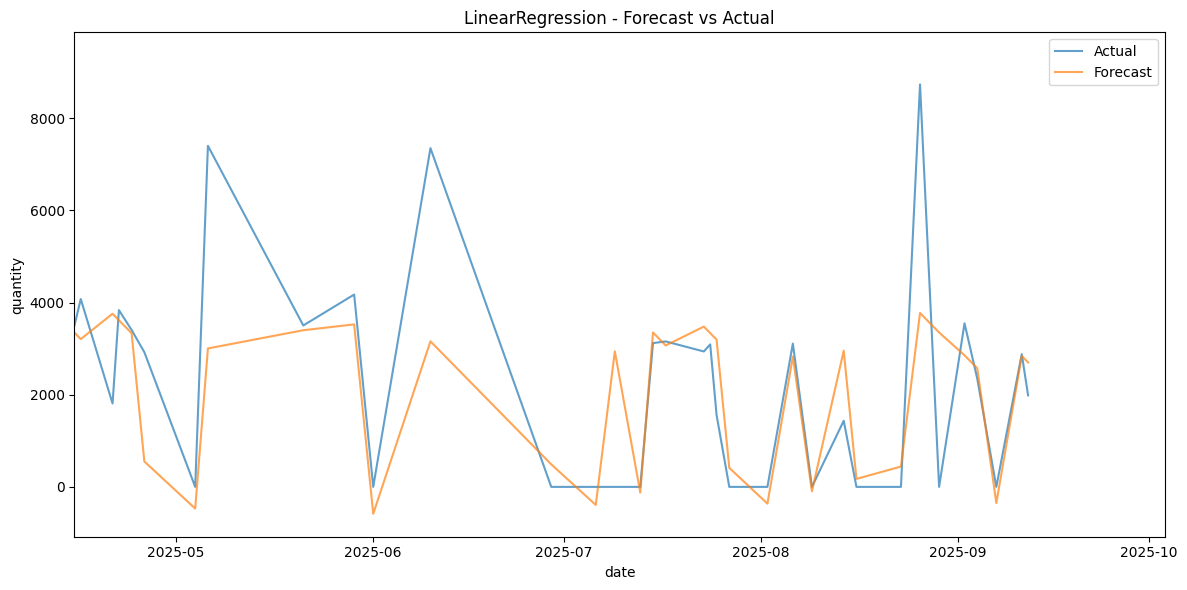

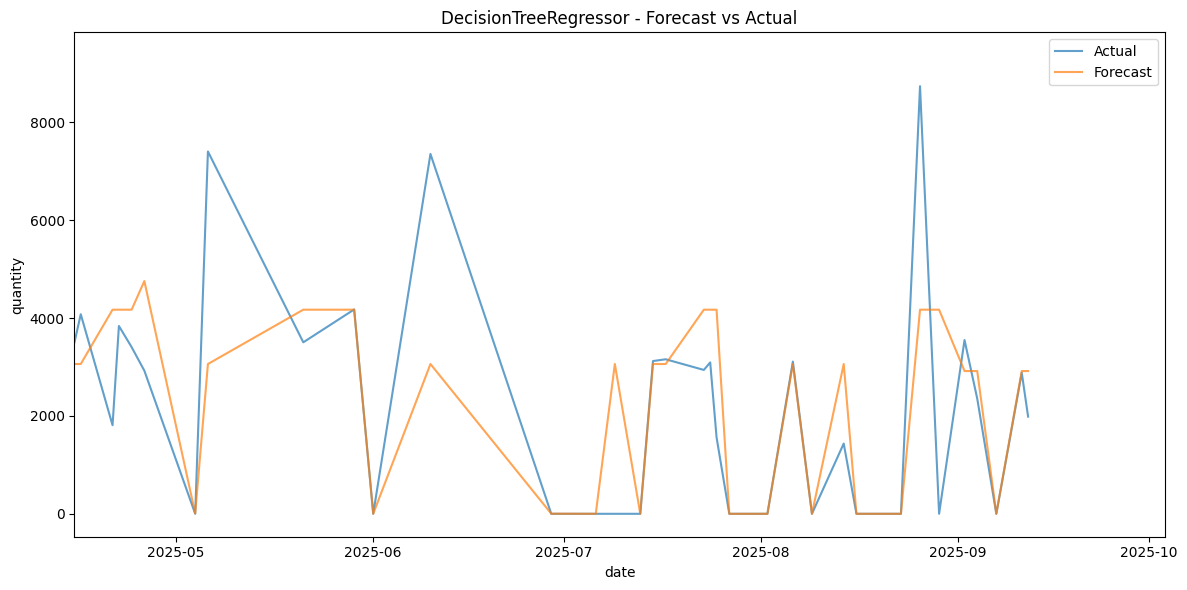

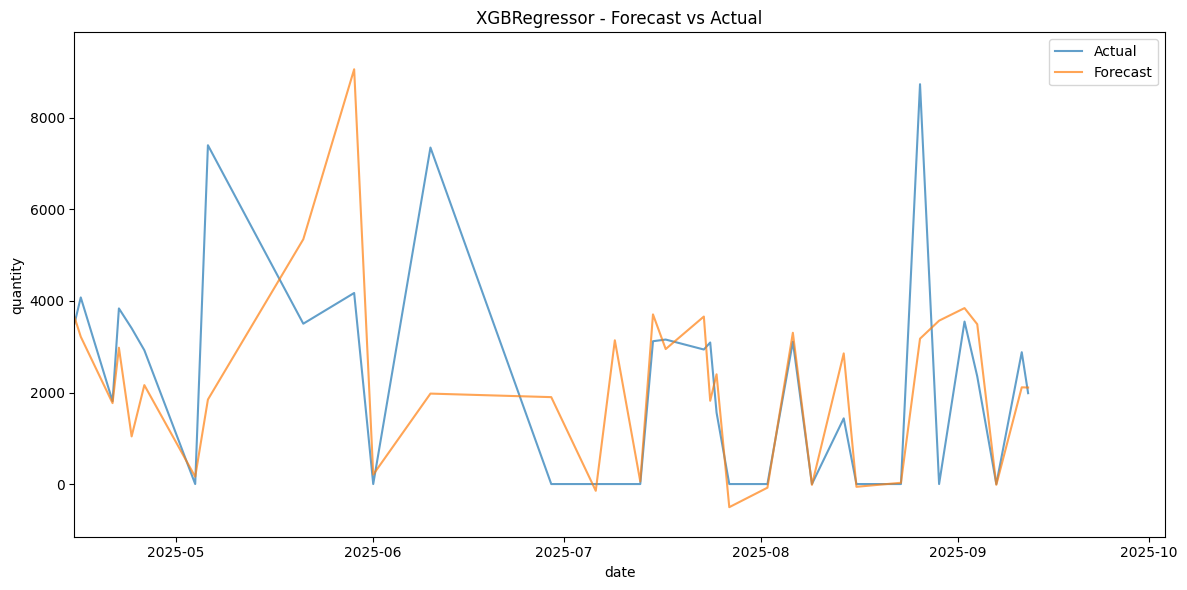

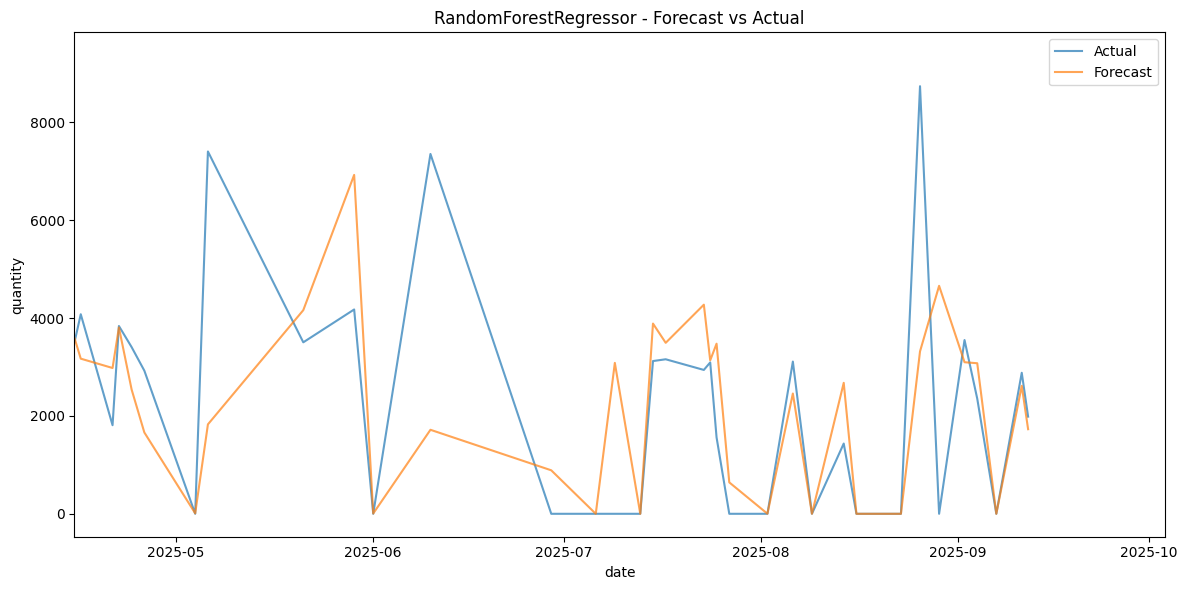

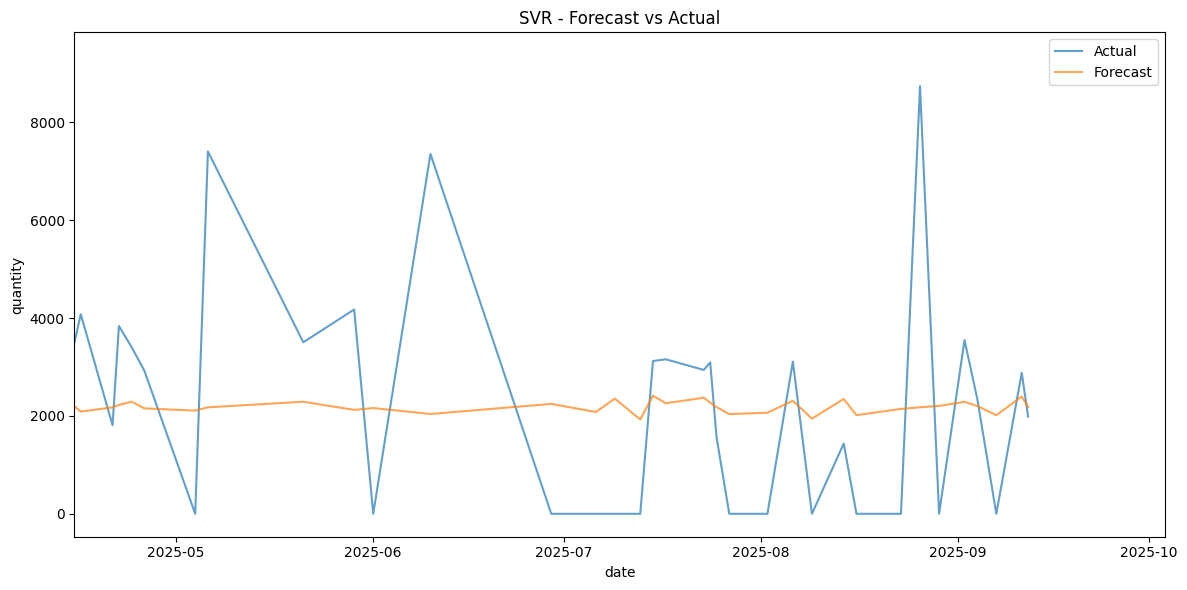

In [14]:
results_df = pd.DataFrame({
    'quantity': y_test,
    'LinearRegression quantity': y_pred_lin,
    'DecisionTreeRegressor quantity': y_pred_dtr,
    'XGBRegressor quantity': y_pred_xgb,
    'RandomForestRegressor quantity': y_pred_rf,
    'SVR quantity': y_pred_svr
})

for column in results_df.columns:
    if column != 'quantity':
        create_dashboard(results_df, column.replace(' quantity', ''))

## Feature Importance (Linear Regression)

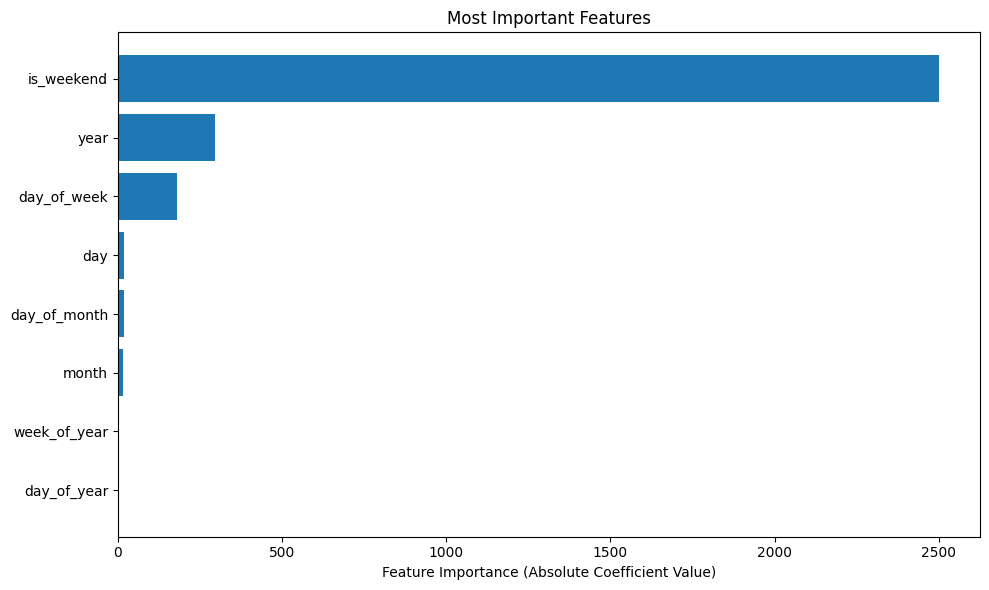

In [15]:
coefficients = model_lin.coef_
feature_names = X_train.columns

feature_importance =s pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Importance': np.abs(coefficients)
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(
    feature_importance['Feature'][:10],
    feature_importance['Importance'][:10]
)
plt.xlabel("Feature Importance (Absolute Coefficient Value)")
plt.title("Most Important Features")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()